In [1]:
import pandas as pd
import requests
from io import StringIO
import time
def monthly_report(year, month):
    
    # 假如是西元，轉成民國
    if year > 1990:
        year -= 1911
    
    url = 'https://mops.twse.com.tw/nas/t21/sii/t21sc03_'+str(year)+'_'+str(month)+'_0.html'
    if year <= 98:
        url = 'https://mops.twse.com.tw/nas/t21/sii/t21sc03_'+str(year)+'_'+str(month)+'.html'
    
    # 偽瀏覽器
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    
    # 下載該年月的網站，並用pandas轉換成 dataframe
    r = requests.get(url, headers=headers)
    r.encoding = 'big5'

    dfs = pd.read_html(StringIO(r.text), encoding='big-5')

    df = pd.concat([df for df in dfs if df.shape[1] <= 11 and df.shape[1] > 5])
    
    if 'levels' in dir(df.columns):
        df.columns = df.columns.get_level_values(1)
    else:
        df = df[list(range(0,10))]
        column_index = df.index[(df[0] == '公司代號')][0]
        df.columns = df.iloc[column_index]
    
    df['當月營收'] = pd.to_numeric(df['當月營收'], 'coerce')
    df = df[~df['當月營收'].isnull()]
    df = df[df['公司代號'] != '合計']
    
    # 偽停頓
    time.sleep(5)

    return df

In [2]:
monthly_report_2021_08 = monthly_report(2021, 8)

In [4]:
import datetime
import pandas as pd
import time

data = {}
#往前尋找幾個月份
n_months = 25
now = datetime.datetime.now()

year = now.year
month = now.month
while len(data) < n_months:
    print("parsing", year, month)

    # 使用 crawPrice 爬資料
    try:
        data["%d-%d-01"%(year, month)] = monthly_report(year, month)
    except Exception as e:
        print("get 404, please check if the revenues are not revealed")

    # 減一個月
    month -= 1
    if month == 0:
        month = 12
        year -= 1

time.sleep(3)

parsing 2021 10
get 404, please check if the revenues are not revealed
parsing 2021 9
parsing 2021 8
parsing 2021 7
parsing 2021 6
parsing 2021 5
parsing 2021 4
parsing 2021 3
parsing 2021 2
parsing 2021 1
parsing 2020 12
parsing 2020 11
parsing 2020 10
parsing 2020 9
parsing 2020 8
parsing 2020 7
parsing 2020 6
parsing 2020 5
parsing 2020 4
parsing 2020 3
parsing 2020 2
parsing 2020 1
parsing 2019 12
parsing 2019 11
parsing 2019 10
parsing 2019 9


In [5]:
data['2021-9-01']

,公司代號,公司名稱,備註,上月比較增減(%),上月營收,去年同月增減(%),去年當月營收,當月營收,前期比較增減(%),去年累計營收,當月累計營收
0,1101,台泥,"以上營收不包含停業部門營收:110年9月 0 仟元暨109年9月710,192仟元；110年...",7.06,8964476,6.22,9034955,9597804,0.61,76433746,76905616
1,1102,亞泥,-,8.87,7193266,7.92,7256519,7831470,13.28,54564173,61810724
2,1103,嘉泥,-,21.25,166022,23.12,163492,201306,11.72,1481525,1655224
3,1104,環泥,-,22.50,431224,17.15,450890,528251,12.13,3886551,4358224
4,1108,幸福,-,7.99,249977,-29.10,380768,269964,-13.49,3358346,2905016
...,...,...,...,...,...,...,...,...,...,...,...
58,9942,茂順,-,-8.04,336002,22.39,252441,308967,37.15,2057192,2821625
59,9944,新麗,-,-5.88,178668,-10.53,187955,168152,12.37,1794807,2016927
60,9945,潤泰新,主係建案交屋認列及子公司潤弘業務正於大量施工階段，以致本年累計營收較去年同期增加。,-44.68,3573571,2.56,1927387,1976853,55.29,12935512,20087739
61,9955,佳龍,"營收較去年同期減少,主要係因本期黃金價格下跌及黃金銷售量減少所致。",-15.21,109319,-55.87,210035,92684,-43.01,1907325,1086937


In [6]:
for k in data.keys():
    data[k].index = data[k]["公司代號"]
    #data[k].index = data[k]["公司名稱"]

df = pd.DataFrame({k:df["當月營收"] for k, df in data.items()}).transpose()
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df_T=df.T #行列轉置
#df_T
data['2020-10-01'].loc['1101']['公司名稱'] + "_" + data['2020-10-01'].loc['1101']['公司代號']

'台泥_1101'

In [7]:
df['1101']

2019-09-01    10120251.0
2019-10-01    11211942.0
2019-11-01    11678701.0
2019-12-01    12349908.0
2020-01-01     7502141.0
2020-02-01     5000692.0
2020-03-01     9473250.0
2020-04-01    10216799.0
2020-05-01    10285516.0
2020-06-01     9961312.0
2020-07-01    10178622.0
2020-08-01     9885013.0
2020-09-01     9745147.0
2020-10-01    10293900.0
2020-11-01    10889658.0
2020-12-01    10933035.0
2021-01-01     8596261.0
2021-02-01     4536849.0
2021-03-01     9779716.0
2021-04-01     9672128.0
2021-05-01     9832764.0
2021-06-01     8480821.0
2021-07-01     8319971.0
2021-08-01     8964476.0
2021-09-01     9597804.0
Name: 1101, dtype: float64

DatetimeIndex(['2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01'],
              dtype='datetime64[ns]', freq=None)


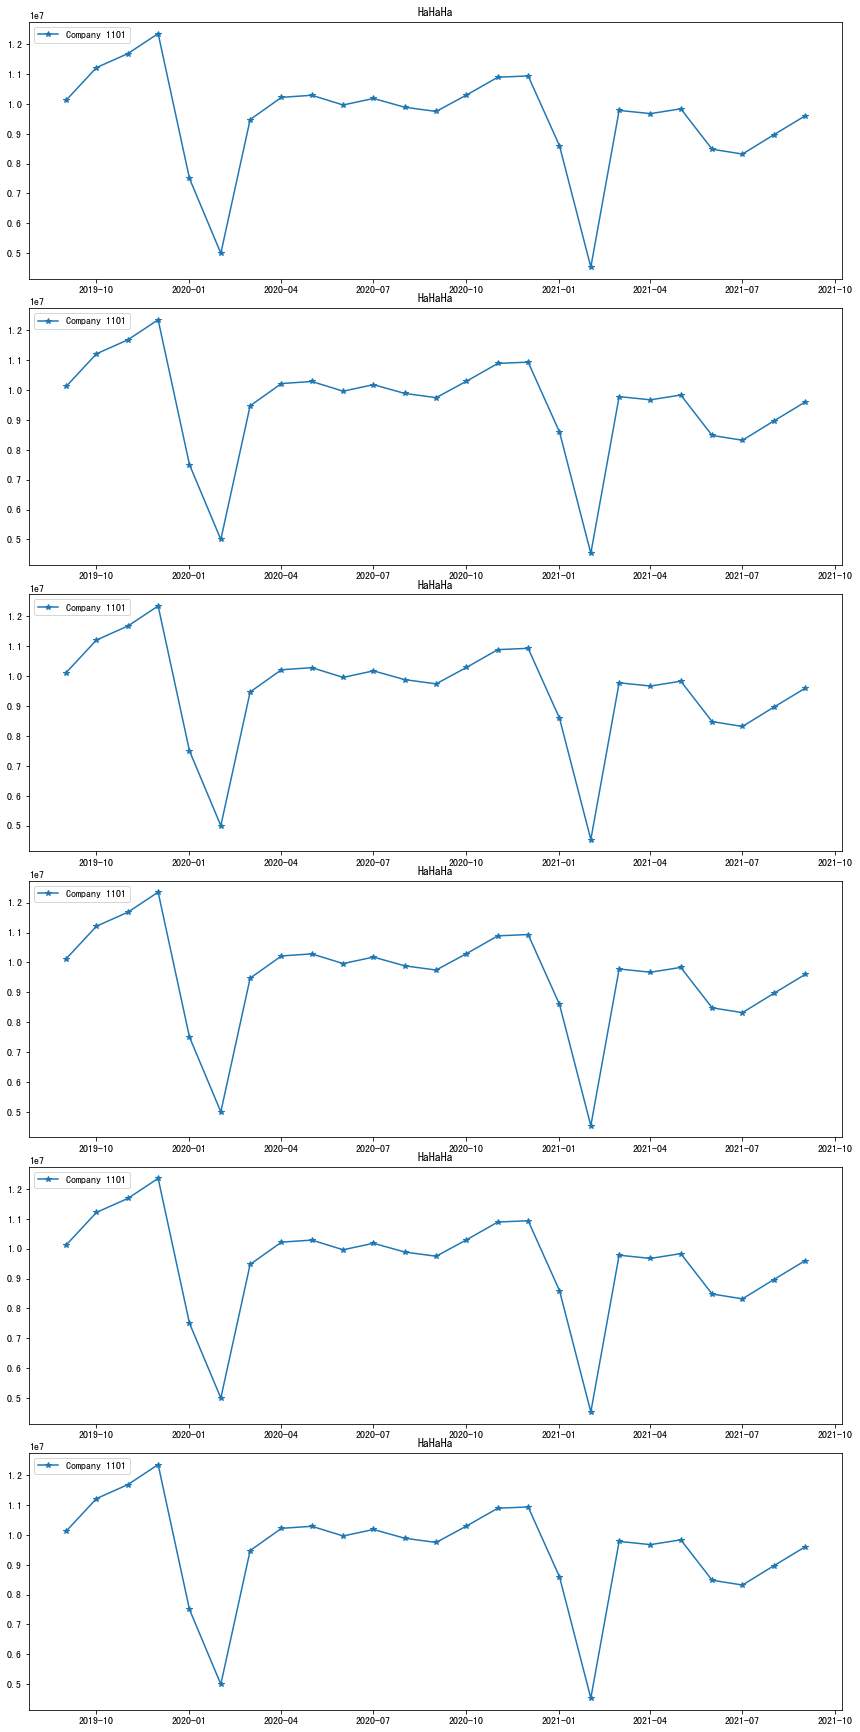

In [13]:
import matplotlib.pyplot as plt
num_subplots = 6
fig, ax = plt.subplots(num_subplots, figsize=(4*3,24)) #(y,x)
fig.subplots_adjust(hspace=2.4, wspace=2.4) #設定子圖的間隔
fig.tight_layout()
print(df['1101'].index)

for i in range(0, num_subgraph):
    ax[i].plot(df['1101'], '-', label="營收", marker="*")
    ax[i].legend(['Company 1101', 'last 12 month revenue'], loc='upper left')
    ax[i].set_title('HaHaHa')
    #plt.text(0.5, 0.5, str((6, 1, i)), fontsize=18, ha='center')

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)


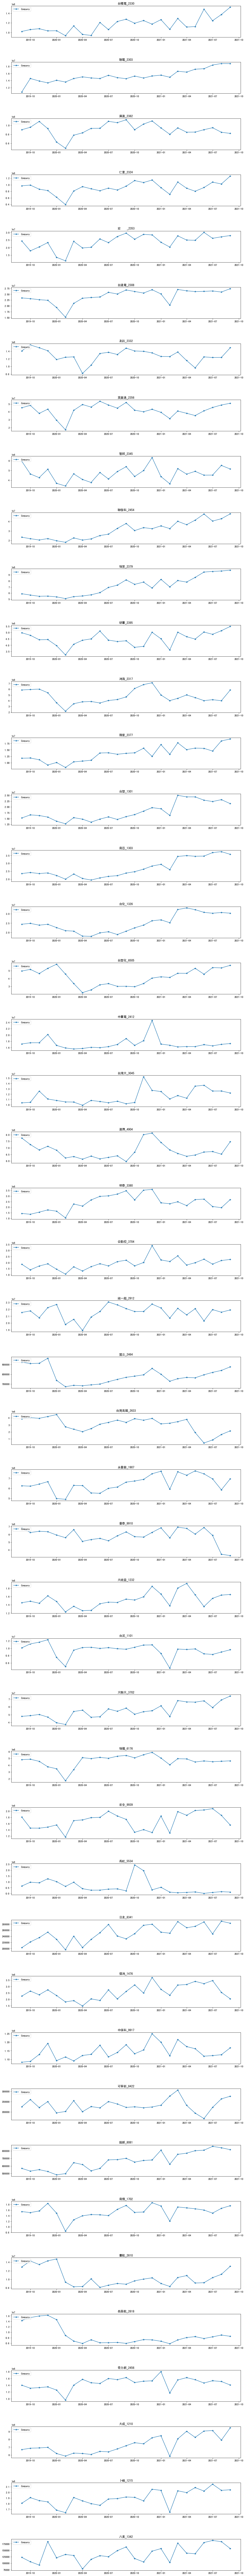

In [8]:
import matplotlib.pyplot as plt
#columns = list(df) # company list
columns = ['2330','2303','2382','2324','2353','2308','2332','2356','2345','2454','2379','2395','2317','2377','1301',
           '1303','1326','6505','2412','3045','4904','3380','3704','2912','2464','2633','1907','9910','1232','1101',
           '3702','6176','9939','5534','8341','1476','9917', '8422','8081','1702','2610','2618','2456','1210','1215','1342']
plt.rcParams['font.family'] = 'SimHei' 

fig ,ax = plt.subplots(len(columns), figsize=(4*4,len(columns)*4)) #(x,y)
fig.subplots_adjust(hspace=0.8, wspace=0.8) #設定子圖的間隔
#fig.tight_layout()

idx = 0
for i in columns:
    ax[idx].plot(df[i], '-', label="income by month", marker="*")
    ax[idx].legend(['Company', 'last 12 month revenue'], loc='upper left')
    #ax[idx].set_title(i)
    ax[idx].set_title(data['2020-10-01'].loc[i]['公司名稱']+"_"+data['2020-10-01'].loc[i]['公司代號'])
    #plt.text(0.5, 0.5, str((6, 1, i)), fontsize=18, ha='center')
    idx = idx + 1